# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Первичный осмотр данных

In [3]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#проверка на повторы 

display(data_0.duplicated().sum())
display(data_1.duplicated().sum())
display(data_2.duplicated().sum())

#проверка на повторы по id объекта
display(data_0['id'].duplicated().sum())
display(data_1['id'].duplicated().sum())
display(data_2['id'].duplicated().sum())

0

0

0

10

4

4

**Выводы:**

 - Для каждого региона есть по 100 000 объектов
 -  с типом данных и пропусками проблем нет
 - полностью ни одна строка не повторяется, но есть незначительное число повторов по id объектов. Это могут быть или ошибочные данные, или "перезапись" с обновленными данными. В любом случае, их очень мало и повторы можно отбросить

Данные по трем регионам будем исследовать отдельно. Поэтому, чтобы трижды не повторять все блоки, создаем один общий датафрейм с дополнительным признаком 'region'

In [7]:
#создаем дополнительный столбец с индексом региона
data_0['region']=0
data_1['region']=1
data_2['region']=2

#объедиение в один датафрейм
data = data_0.append(data_1).append(data_2)

In [8]:
data.drop_duplicates(subset = ['id'],inplace = True) #убираем дубликаты

## Обучение и проверка модели

Чтобы не плодить переменные, все результаты будем записывать в датафреймы. Предсказанный средний запас и RMSE записываем в массив mean_RMSE. В дальнейшем нам пригодятся реальные и предсказанные значения для валидационных выборок для всех трех регионов. Поэтому эти данные записываем в отдельный массив - results

In [9]:
mean_RMSE = pd.DataFrame()
results =pd.DataFrame()

for i in range(0,3):
    
    features = data.loc[data['region']==i].drop(columns = ['product','id', 'region'], axis =1)
    target = data.loc[data['region']==i]['product']   
    features_train, features_valid,  target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=1)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    
    results = results.append({'predicted':predicted_valid.tolist(),'real':target_valid.tolist()}, ignore_index = True)
    
    mean_RMSE = mean_RMSE.append({'RMSE': mse**.5, 'средний запас':predicted_valid.mean()}, ignore_index=True)
    
mean_RMSE

,RMSE,средний запас
0,37.526919,92.546292
1,0.892727,68.601247
2,39.846444,94.998673


<AxesSubplot:>

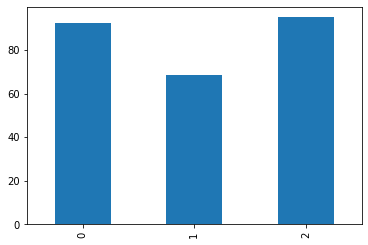

In [10]:
mean_RMSE['средний запас'].plot(kind='bar')

**Выводы:**

 - в регионе с индексом 1 самый низкий средний запас, зато самый маленький RMSE. Получается, что регрессия сработала лучше всего именно для этого региона
 - средний запас и RMSE в регионах 0 и 2 очень близки


## Подготовка к расчёту прибыли

In [11]:
#запись ключевых значений в переменные

buget = 10000000000
barrel_price =  450
top_amount = 200
new_mines_amount = 500

Найдем минимальный объем скважины, который будет как минимум компенсировать расходы

In [12]:
min_volume = buget/top_amount/barrel_price/1000
min_volume

111.11111111111111

**Выводы**

 - для всех трех регионов средний запас ниже минимального неубыточного
 - дальше всего от необходимого минимума регион 2

## Расчёт прибыли и рисков 

In [13]:
#функция для расчета прибыли 

def profit(real, predicted, count):
    predicted = predicted.sort_values(ascending=False)
    selected = real[predicted.index][:count]
    return (barrel_price*1000*selected.sum()-10**10)/1_000_000_000  #здесь делим на миллиард, чтобы цифры отображались удобнее

In [14]:
#функция, реализующая бутстреп

def bootstrap(real,predicted,count):
    
    state = np.random.RandomState(1)
    
    real = pd.Series(real)
    predicted = pd.Series(predicted)
    count = 0
    revenues_bs = []
    bs_iterations = 1000
    
    for i in range(bs_iterations):
       
        real_subsample = real.sample(n=new_mines_amount, random_state=state,  replace=True)
        predicted_subsample = predicted[real_subsample.index] 
        revenue = profit(real_subsample,predicted_subsample,top_amount)
        revenues_bs.append(revenue)
        
        if revenue < 0:
        #if revenue < buget/1000000000:
            count+=1

    revenues_bs = pd.Series(revenues_bs)
    
    lower = revenues_bs.quantile(q=0.025) #расчет нижнего квантиля 
    upper = revenues_bs.quantile(q=0.975) #расчет верхнего квантиля
    mean = revenues_bs.mean() #расчет среднего дохода
    loss_prob = count/bs_iterations  # вероятность того, что выбранные 200 скважин окажутся убыточными
    
    return mean,lower,upper, loss_prob

In [15]:
#применение функций для всех трех регионов

revenues = pd.DataFrame()

for i in range(0,3):
    
    bs_result = bootstrap(pd.Series(results['real'][i]),
                          pd.Series(results['predicted'][i]),top_amount)
    
    revenues = revenues.append({'mean_revenue': bs_result[0],
                                'lower': bs_result[1], 
                                'upper':bs_result[2],
                                'loss_probability':bs_result[3]}, ignore_index=True)
    
revenues

,loss_probability,lower,mean_revenue,upper
0,0.062,-0.140001,0.456085,0.993285
1,0.015,0.046517,0.475111,0.897198
2,0.046,-0.105032,0.472886,1.027246


**Выводы:**

 - В регионах с индексами 0 и 2 вероятность получить убыточный набор скважин больше 2,5% 
 - Только в регионе с индексом 1 доверительный интервал прибыли не уходит в минус
 - При этом средняя прибыль оказывается примерно одинаковой во всех регионах
 - несмотря на то, что в регионе 1 самый низкий средний запас, распределение скважин таково, что лишь с вероятность 1,5% набор из 200 скважин окажется убыточным

 
**Для дальнейшей разработки рекомендуется регион с индексом 1**